# Load the test and training data

In [1]:
import numpy as np
import pandas as pd
import json
from dscribe.descriptors import CoulombMatrix
from ase import Atoms
import matplotlib.pyplot as plt


test = pd.read_json('data/test.json')
train = pd.read_json('data/train.json')
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))


In [2]:
print('Train data shape: {}'.format(train.shape))
train.head()

Train data shape: (8000, 4)


,id,formula,atoms,hform
0,5154,Zr2BO2,"(Atom('Zr', [1.6878604657, 0.892285133, 8.1345...",-2.037877
1,984,Ni2S6,"(Atom('Ni', [1.1571403137, 0.934725185, 12.234...",-0.091020
2,1634,Cd4K2Cl6O6Te2,"(Atom('Cd', [2.7840261751, 5.6922402759, 26.71...",-1.109751
3,1872,Hf4H2N3O2,"(Atom('Hf', [0.0, 1.8677827772, 12.2421466347]...",-1.609142
4,2977,Sc2Te2,"(Atom('Te', [0.0003850118, 0.0002469812, 7.461...",-0.854593


In [3]:
print('Test data shape: {}'.format(test.shape))
test.head()

Test data shape: (4000, 3)


,id,formula,atoms
0,8538,HfZrSTe2,"(Atom('S', [-1.0327079693, 4.2080182974, 22.81..."
1,9052,Nb2P2Te6,"(Atom('Nb', [0.3517632032, -0.2042419274, 9.20..."
2,10503,Au2InI2Se2,"(Atom('Se', [0.22384118560000002, 0.8131388722..."
3,611,AuTlO6Sb2,"(Atom('Au', [0.0002076097, -0.0001198635000000..."
4,7212,NbBr2,"(Atom('Nb', [6.208919093000001e-19, -1.3716433..."


In [4]:
train.describe()

,id,hform
count,8000.000000,8000.000000
mean,7903.234875,-0.622866
std,4560.292278,0.672705
min,1.000000,-4.016701
25%,4020.750000,-0.981515
50%,7945.000000,-0.474902
75%,11855.500000,-0.160427
max,15732.000000,1.767721


In [5]:
species = []
number_of_atoms = []
atomic_numbers = []
for atom in pd.concat([train.atoms,test.atoms]):
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(len(atom))

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)
max_atomic_number = np.max(atomic_numbers)

In [6]:
max_number_of_atoms

20

In [7]:
from ase.visualize import view
view(train.atoms[1])

<Popen: returncode: None args: ['c:\\Users\\asbjo\\anaconda3\\python.exe', '...>

# Creating SOAP fingerprint

In [40]:
from dscribe.descriptors import SOAP,CoulombMatrix

r_cut = 6
n_max = 2
l_max = 2

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=True,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
    average = 'inner'
)

In [41]:
v = soap.create(train.atoms[1])

In [42]:
np.shape(v)

(23250,)

In [11]:
np.shape(np.nonzero(v))

(1, 30)

In [12]:
soap_mats = np.zeros((len(train.atoms),23250))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 1:
        print(i)
    soap_mats[i,:] = soap.create(atoms)
    

1
1001
2001
3001
4001
5001
6001
7001


In [13]:
np.shape(soap_mats)

(8000, 23250)

# Initialize X and y split into test and training

In [15]:
X = pd.DataFrame(data = soap_mats, index=train.id)
y = train['hform']

In [49]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=251)


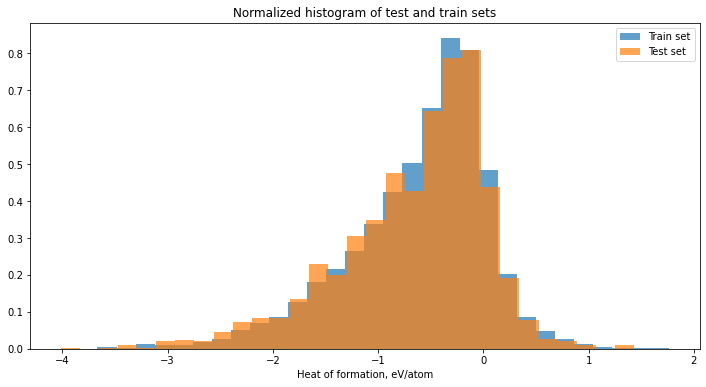

In [50]:
plt.figure(figsize = (12, 6))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.title("Normalized histogram of test and train sets")
plt.xlabel("Heat of formation, eV/atom")
plt.legend()
plt.show()

# PCA for feature reduction

In [16]:
from sklearn.decomposition import PCA

n_comp_PCA = 200

pca = PCA(n_components = n_comp_PCA).fit(X)
X_PCA = pca.transform(X)
print("With {} PCA components {var:0.4f}% of the variance is explained".format(n_comp_PCA, var = 100*np.sum(pca.explained_variance_ratio_)))

With 200 PCA components 92.6683% of the variance is explained


In [17]:
np.shape(X_PCA)


(8000, 200)

# kNN model

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import model_selection
from sklearn.metrics import mean_squared_error as mse
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

CV = model_selection.KFold(10, shuffle=True, random_state=2)


optimal_nn_list = []
min_error_list = []
rmse_v = np.zeros(20)

for train_index, val_index in CV.split(X_PCA,y):
    for l in range(1,21):
        X_train = X_PCA[train_index]
        X_val = X_PCA[val_index]
        y_train = y[train_index]
        y_val = y[val_index]
        model = KNeighborsRegressor(n_neighbors = l, weights='distance')
        model.fit(X_train,y_train)
        test_pred = model.predict(X_val)
        rmse_v[l-1] = rmse(y_val, test_pred)
    
    min_error = np.min(rmse_v)
    opt_nn = np.argmin(rmse_v) + 1
    optimal_nn_list.append(opt_nn)
    min_error_list.append(min_error)



In [36]:
optimal_nn_list

[3, 3, 4, 7, 3, 4, 6, 5, 4, 5]

In [23]:
min_error_list

[0.3298989329256367,
 0.3220740340800078,
 0.3323837032272322,
 0.32716525642030864,
 0.31737744997717193,
 0.31008268133282396,
 0.31364787149103723,
 0.3300354394416561,
 0.32979924175308145,
 0.3299712433244985]

In [24]:
optimal_nn_list[np.argmin(min_error_list)]

4

In [25]:
# Try a model with just one split and compute RMSE, with 4 neigbours a sthat was deemed optimal in the cross validation
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=251)

model = KNeighborsRegressor(n_neighbors = 4, weights='distance')
model.fit(X_train,y_train)
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

print('Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
print('Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))


Train RMSE = 0.00
Test RMSE = 0.30


# Prepare submission to Kaggle

In [26]:
soap_mats_kag = np.zeros((len(test.atoms),23250))
for i,atoms in enumerate(test.atoms):
    if i%1000 == 1:
        print(i)
    soap_mats_kag[i,:] = soap.create(atoms)

1
1001
2001
3001


In [27]:
X_kag = pd.DataFrame(data = soap_mats_kag, index=test.id)

In [29]:
X_kag_PCA = pca.transform(X_kag)

In [30]:
model = KNeighborsRegressor(n_neighbors = 4, weights='distance')
model.fit(X_PCA,y)

KNeighborsRegressor(n_neighbors=4, weights='distance')

In [32]:
model.predict(X_kag_PCA)

Y_kaggle = model.predict(X_kag_PCA)
Y_kaggle

array([-0.87223901, -0.13362396, -0.41531964, ..., -0.56508479,
       -0.27593893, -1.22330694])

In [34]:
kNN_SOAP_prediction_dataframe = pd.DataFrame(data = {'id':test.id,
                                                 'hform':Y_kaggle})
kNN_SOAP_prediction_dataframe.head(n=20)

,id,hform
0,8538,-0.872239
1,9052,-0.133624
2,10503,-0.415320
3,611,-0.894922
4,7212,-0.586299
5,10750,-1.283395
6,1646,-1.031837
7,6893,-1.602345
8,4403,-0.247647
9,1641,-0.534329


In [35]:
kNN_SOAP_prediction_dataframe.to_csv('kNN_SOAP_predictions.csv',index=False)